# 使用高维线性模型直观感受正则化
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

---
特征数量假设为200, 训练样本很小假设为20, 测试样本大小则为100

In [15]:
import torch
from torch.utils import data

def syntheticData(w_true, b_true, n, delta=0.01):
    X = torch.randn(n, len(w_true))
    y = b_true + (X*w_true).sum(dim=1, keepdim=True) + torch.normal(0, delta, size=(n, 1))
    return X, y

train_n, test_n, num_inputs = 20, 100, 200
w_true, b_true = torch.ones(num_inputs)*0.01, 0.05
train_X, train_y = syntheticData(w_true, b_true, train_n)
test_X, test_y = syntheticData(w_true, b_true, test_n)
train_dataset = data.TensorDataset(train_X, train_y)
test_dataset = data.TensorDataset(test_X, test_y)
batch_size=5
train_iter = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_iter = data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


In [16]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([20, 200]),
 torch.Size([20, 1]),
 torch.Size([100, 200]),
 torch.Size([100, 1]))

In [30]:
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

# 定义线性回归模型
def init_params():
    w = torch.normal(0, 0.1, size=(num_inputs, 1), requires_grad=True)
    b = torch.tensor(0.0, requires_grad=True)
    return w, b
w, b = init_params()

In [57]:
def net(X):
    return torch.matmul(X, w)+b
def loss(y_hat, y):
    return (torch.pow(y_hat-y.reshape(y_hat.shape), 2).sum())/y.shape[0]
def l2_penalty(w):
    return (w.pow(2).sum())/w.shape[0]
def l1_penalty(w):
    return (w.abs().sum())/w.shape[0]
w.shape, b.shape, loss(net(train_X), train_y), l2_penalty(w), l1_penalty(w)

(torch.Size([200, 1]),
 torch.Size([]),
 tensor(2.2258, grad_fn=<DivBackward0>),
 tensor(0.0107, grad_fn=<DivBackward0>),
 tensor(0.0811, grad_fn=<DivBackward0>))

In [58]:
def lossEvaluate(data_iter, model):
    cost, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            cost += loss(model(X), y)
            n += len(y)
    return cost/n
lossEvaluate(train_iter, net), lossEvaluate(test_iter, net)

(tensor(0.4452), tensor(0.4913))

In [62]:
def sgd(params, batch_size, lr=0.01):
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

def train(train_iter, test_iter, num_epoch=200, lamb=0.0, penalty=l2_penalty):
    train_loss, test_loss = [], []
    for epoch in range(num_epoch):
        for X, y in train_iter:
            l = loss(net(X), y) + lamb*penalty(w)
            l.backward()
            sgd([w, b], len(y))
        train_loss.append(lossEvaluate(train_iter, net))
        test_loss.append(lossEvaluate(test_iter, net))
    return train_loss, test_loss

In [63]:
# 绘图函数
from matplotlib import pyplot as plt
def lossPrint(train_loss, test_loss):
    plt.plot(range(len(train_loss)), train_loss, label="train_loss", linestyle=":")
    plt.plot(range(len(test_loss)), test_loss, label="test_loss", linestyle="--")
    plt.xlabel("epoch iter times")
    plt.ylabel("loss evaluate")
    plt.legend()
    plt.show()

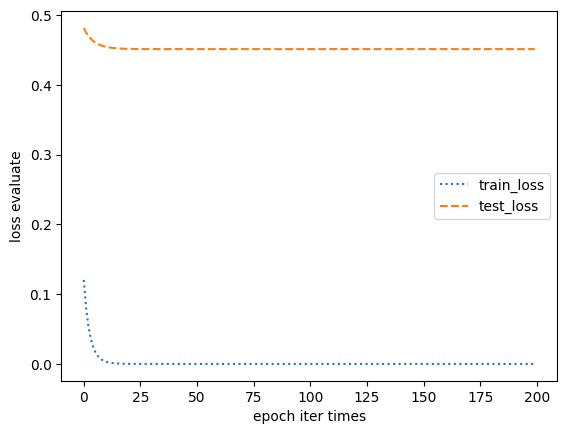

(tensor(4.5218e-15), tensor(0.4515))

In [69]:
# 不使用正则化
w, b = init_params()
trl0, tel0 = train(train_iter, test_iter)
lossPrint(trl0, tel0)
trl0[-1], tel0[-1]

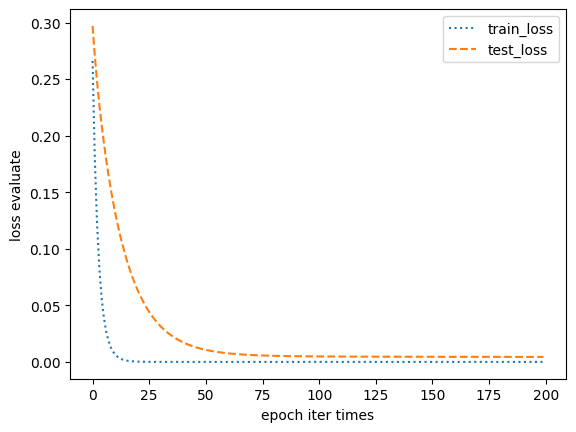

(tensor(0.0001), tensor(0.0046))

In [77]:
# 使用l2正则化
w, b = init_params()
trl0, tel0 = train(train_iter, test_iter, lamb=500)
lossPrint(trl0, tel0)
trl0[-1], tel0[-1]

In [79]:
# 接下来绘制trl0[-1], tel0[-1]随lamb的变化曲线
def lambLoss(lamb_num = 500, penalty=l2_penalty):
    tr_lb, te_lb = [], []
    for lb in range(lamb_num):
        w, b = init_params()
        trl0, tel0 = train(train_iter, test_iter, lamb=lb, penalty=l2_penalty)
        tr_lb.append(trl0[-1])
        te_lb.append(tel0[-1])
    return tr_lb, te_lb

def lambPrint(tr_lb, te_lb):
    plt.plot(range(len(tr_lb)), tr_lb, label="train_loss", linestyle=":")
    plt.plot(range(len(te_lb)), te_lb, label="test_loss", linestyle="--")
    plt.xlabel("regularization constant $\lambda$")
    plt.ylabel("loss evaluate")
    plt.legend()
    plt.show()


In [ ]:
# 使用l2_penalty下train_loss, test_loss随lambda的变化曲线
tr_lb, te_lb = lambLoss()
lambPrint(tr_lb, te_lb)